In [1]:
import os, random
import cv2
import math
import librosa
import matplotlib.pyplot as plt
font = {'size'   : 5}
plt.rc('font', **font)

import numpy as np
import pandas as pd
from tqdm import tqdm

from collections import Counter
import concurrent.futures

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import WeightedRandomSampler
from torchvision.models import efficientnet
from torchvision.transforms import transforms
import torchvision

import tensorflow_hub as hub

import timm

import albumentations as albu

import scikitplot as skplt
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit, KFold
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.preprocessing import LabelEncoder

from glob import glob
from IPython.display import display, Audio

import cupy as cp
from cupyx.scipy import signal as cupy_signal
import yaml

from metric import score

import wandb

import plotly.graph_objects as go
import plotly.express as px

from ast import literal_eval

c:\Users\hoang\anaconda3\envs\bird\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\hoang\anaconda3\envs\bird\lib\site-packages\cupyx\jit\_interface.py:173: FutureWarning: cupyx.jit.rawkernel is experimental. The interface can change in the future.
  cupy._util.experimental('cupyx.jit.rawkernel')


In [2]:
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: Currently logged in as: lhkaay (lhklevi). Use `wandb login --relogin` to force relogin


True

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


In [4]:
try:
    with open('config.yaml', 'r') as f:
        default_config = yaml.load(f, Loader=yaml.SafeLoader)
except:
    pass

default_config

{'VERSION': 'v5.1',
 'DESCRIPTION': 'reproduce legend v4.0',
 'DATA_PATH': 'inputs',
 'LOAD_SPEC_DATA': ['data/melspec_googletop5_256_256_24_wide.npy'],
 'IMAGE_SIZE': 256,
 'SEED': 24,
 'SECOND_LABEL': 1,
 'SAMPLE_RATE': 32000,
 'MIN_FREQ': 20,
 'MAX_FREQ': 16000,
 'N_FFT': 2048,
 'WIN_SIZE': 412,
 'WIN_LAP': 100,
 'N_MEL': 128,
 'HOP_LENGTH': 512,
 'NORMALIZED': True,
 'CENTER': True,
 'PAD_MODE': 'constant',
 'NORM': 'slaney',
 'MEL_SCALE': 'slaney',
 'VolumeGain': True,
 'AddShortNoises': True,
 'AddGaussianNoise': True,
 'TimeStretch': True,
 'AddColorNoise': True,
 'AddBackgroundNoise': True,
 'XYMasking': True,
 'CoarseDropout': False,
 'HorizontalFlip': True,
 'MixUp': False,
 'CutMix': False,
 'BACKBONE': 'eca_nfnet_l0',
 'EPOCHS': 10,
 'FOLD': 5,
 'BACTHSIZE': 48,
 'LABEL_SMOOTHING': 0.0,
 'LOSS': 'CrossEntropyLoss'}

In [5]:
# Reproducibility
torch.manual_seed(default_config["SEED"])
random.seed(default_config["SEED"])
np.random.seed(default_config["SEED"])

In [6]:
# train_data = dict()
# train_data.update(np.load(default_config["LOAD_SPEC_DATA"][0], allow_pickle=True).item())

# valid_data = dict()
# valid_data.update(np.load(default_config["LOAD_SPEC_DATA"][1], allow_pickle=True).item())

In [6]:
if default_config["LOAD_SPEC_DATA"]:
        all_bird_data = dict()
        for data_path in default_config["LOAD_SPEC_DATA"]:
                all_bird_data.update(np.load(data_path, allow_pickle=True).item())
train_meta = pd.read_csv("inputs/train_metadata.csv")[["filename", "secondary_labels"]]
len(all_bird_data)

84322

In [7]:
# meta_data = pd.read_csv(f"inputs/train_metadata.csv")
# meta_data.drop_duplicates(inplace=True)

# meta_data.reset_index(drop=True, inplace=True)
# meta_data = meta_data[["filename","primary_label", "secondary_labels"]]

In [12]:
meta_data = pd.DataFrame(all_bird_data.items(), columns=["filename","audioarray"])
del all_bird_data

def drop_startidx(x):
    return x.split("_")[0]

def get_primary_label(x):
    return x.split("/")[0]

meta_data["filename"] = meta_data["filename"].apply(drop_startidx)
meta_data['primary_label'] = meta_data["filename"].apply(get_primary_label)

train_meta_data = pd.read_csv(f"{default_config['DATA_PATH']}/train_metadata.csv")
train_meta_data = train_meta_data[["primary_label", "filename"]]

label_list = sorted(train_meta_data["primary_label"].unique())
label_id_list = list(range(len(label_list)))
label2id = dict(zip(label_list, label_id_list))
id2label = dict(zip(label_id_list, label_list))

class_weights = meta_data.groupby(["primary_label"]).size().to_dict()
class_weights = dict((label2id[label], (num/len(meta_data))**(-0.5)) for (label, num) in class_weights.items())
class_weights

meta_data

filename  \
0       asbfly/XC134896.ogg   
1       asbfly/XC134896.ogg   
2       asbfly/XC134896.ogg   
3       asbfly/XC134896.ogg   
4       asbfly/XC134896.ogg   
...                     ...   
84317  zitcis1/XC858550.ogg   
84318  zitcis1/XC858550.ogg   
84319  zitcis1/XC858550.ogg   
84320  zitcis1/XC858550.ogg   
84321  zitcis1/XC858550.ogg   

                                              audioarray primary_label  
0      [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...        asbfly  
1      [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...        asbfly  
2      [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...        asbfly  
3      [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...        asbfly  
4      [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...        asbfly  
...                                                  ...           ...  
84317  [[0.013899469, 0.08589664, 0.046549134, 0.0433...       zitcis1  
84318  [[0.03962333, 0.039623328, 0.06671326, 0.08285...       zitcis1  
84319  [[0.019905366, 0.030830847, 0.048804954, 0.027...       zitcis1  
84320  [[0.009556638, 0.052597396, 0.028134152, 0.014...       zitcis1  
84321  [[0.025032252, 0.025032252, 0.025032252, 0.025...       zitcis1  

[84322 rows x 3 columns]

In [ ]:
# filename = []
# audio_data = []
# primary_label = []
# secondary_labels = []

# for name, data in tqdm(valid_data.items()):
#     filename.append(name.split('_')[0])
#     audio_data.append(data)
#     primary_label.append(name.split('/')[0])
#     secondary_labels.append(meta_data[meta_data['filename']==name.split('_')[0]]['secondary_labels'].to_numpy()[0])

# valid_df = pd.DataFrame({'filename':filename, 'audio_data':audio_data, 'primary_label':primary_label, 'secondary_labels':secondary_labels})
# valid_df
# del valid_data

In [ ]:
# filename = []
# audio_data = []
# primary_label = []
# secondary_labels = []

# for name, data in tqdm(train_data.items()):
#     filename.append(name.split('_')[0])
#     audio_data.append(data)
#     primary_label.append(name.split('/')[0])
#     try:
#         secondary_labels.append(meta_data[meta_data['filename']==name.split('_')[0]]['secondary_labels'].to_numpy()[0])
#     except:
#         secondary_labels.append('[]')

# train_df = pd.DataFrame({'filename':filename, 'audio_data':audio_data, 'primary_label':primary_label, 'secondary_labels':secondary_labels})
# train_df
# del train_data

In [ ]:

# label_list = sorted(train_df["primary_label"].unique())
# label_id_list = list(range(len(label_list)))
# label2id = dict(zip(label_list, label_id_list))
# id2label = dict(zip(label_id_list, label_list))

# class_weights = train_df.groupby(["primary_label"]).size().to_dict()
# class_weights = dict((label2id[label], (num/len(train_df))**(-0.5)) for (label, num) in class_weights.items())
# class_weights

# train_df

In [13]:
import gc
gc.collect()

0

In [14]:
class BirdCLEF_Dataset(torch.utils.data.Dataset):
    def __init__(self, df_data, mode='test'):
        super(BirdCLEF_Dataset).__init__()
        self.df_data = df_data
        self.mode = mode
        self.spec_transform = self.get_spec_transform()

    def __len__(self):
        return len(self.df_data)

    def get_spec_transform(self):
        if self.mode=='train':
            return albu.Compose([
                # albu.Resize(height=default_config["IMAGE_SIZE"], width=default_config["IMAGE_SIZE"], interpolation=cv2.INTER_AREA),
                # albu.MixUp(p=0, reference_data=self.ref_data, read_fn=self.read_fn) if default_config["MixUp"] else albu.NoOp(),
                albu.XYMasking(p=0.3, num_masks_x=(1,3), num_masks_y=(1,3), mask_x_length=(1,10), mask_y_length=(1,10)) if default_config["XYMasking"] else albu.NoOp(),
                albu.HorizontalFlip(p=0.5) if default_config['HorizontalFlip'] else albu.NoOp()
            ])
        else:
            return albu.Compose([
                # albu.Resize(height=default_config["IMAGE_SIZE"], width=default_config["IMAGE_SIZE"], interpolation=cv2.INTER_AREA)
            ])

    def __getitem__(self, index):
        row = self.df_data.iloc[index]
        X = row.audioarray

        birds_id = np.array([label2id[row.primary_label]])
        second_birds = literal_eval(train_meta[train_meta["filename"]==self.df_data.iloc[index].filename]["secondary_labels"].to_numpy()[0])
        if len(second_birds)>0:
            birds_id = np.append(birds_id,[label2id[lbl] for lbl in second_birds if lbl in label_list])
        y = np.zeros(182)
        for id in birds_id:
            y[int(id)] = 1

        transformed = self.spec_transform(image=X)
        X = transformed['image']
        
        X = np.array([X])
        
        return torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)
    
def display_batch (dataset, audio=False):
    fig = plt.figure(figsize=(20,10))
    img_index = np.random.randint(0, len(dataset)-1, 5*10)

    for i in range(len(img_index)):
        img, labels = dataset[img_index[i]]
        
        if isinstance(img, torch.Tensor):
            img = img.detach().numpy()
        
        ax = fig.add_subplot(5, 10, i + 1, xticks=[], yticks=[])
        ax.imshow(np.squeeze(img))
        lbl = [{id2label[label]:round(labels[label].item(),2)} for label in np.where(labels.numpy()>0)[0]]
        ax.set_title(f'ID: {img_index[i]}; Target: {lbl}')

    plt.tight_layout()
    plt.show()

    if (audio):
        try:
            for i in range(len(img_index)):
                filepath = f"inputs/train_audio/{dataset.df_data.iloc[img_index[i]].filename}"
                print(f"{img_index[i]} {filepath}")
                display(Audio(filepath))
        except:
            pass

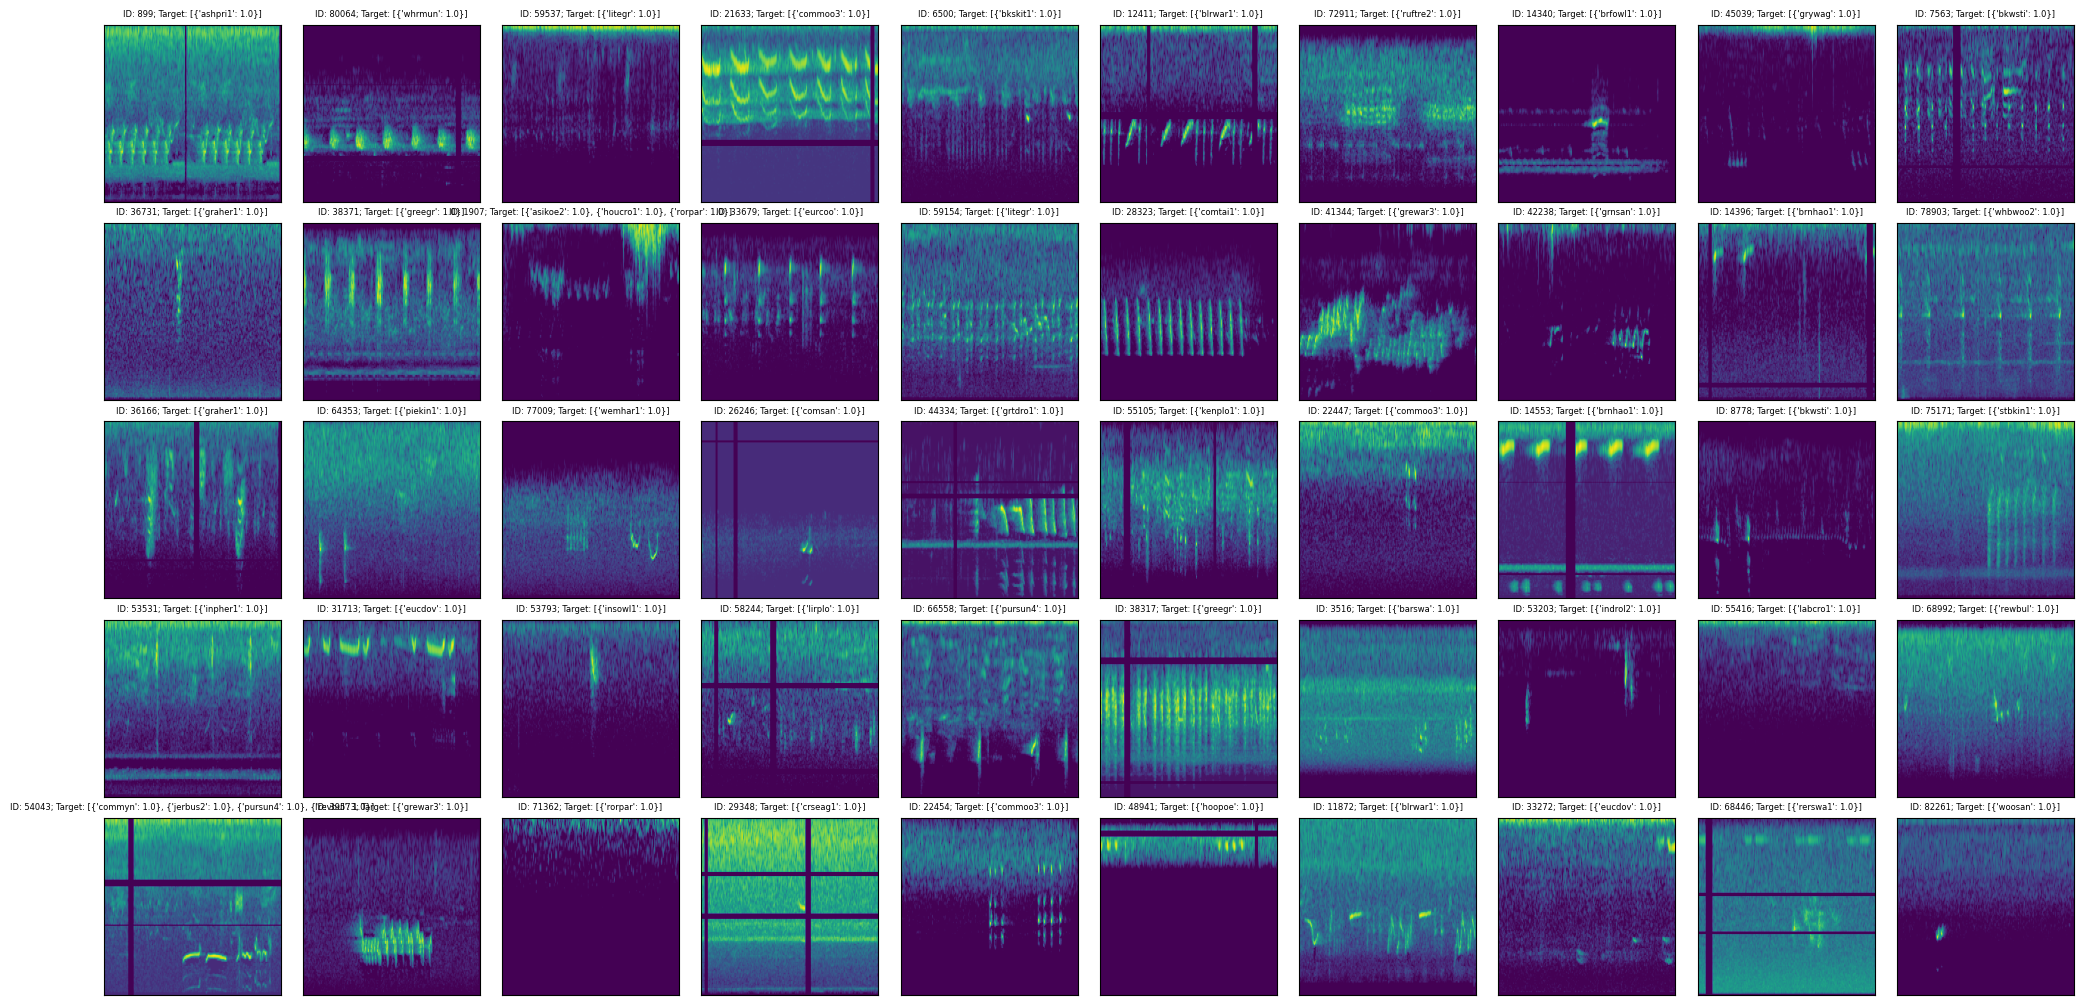

In [15]:
dataset = BirdCLEF_Dataset(meta_data, mode='train')
display_batch(dataset, audio=False)

In [ ]:
# class BirdCLEF_Dataset(torch.utils.data.Dataset):
#     def __init__(self, df_data, bird_transforms=False):
#         super(BirdCLEF_Dataset).__init__()
#         self.df_data = df_data
#         self.bird_transforms = bird_transforms

#     def __len__(self):
#         return len(self.df_data)
    
#     def __getitem__(self, index):
#         X = self.df_data.iloc[index].audioarray
#         if (self.bird_transforms):
#             X = self.bird_transforms(image=X)["image"]
#         X = np.array([X])

#         y = np.array([label2id[self.df_data.iloc[index].primary_label]])
        
#         return torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)
    
# def display_batch (dataset, audio=False):
#     fig = plt.figure(figsize=(20,10))
#     img_index = np.random.randint(0, len(dataset)-1, 5*10)

#     for i in range(len(img_index)):
#         img, labels = dataset[img_index[i]]
        
#         if isinstance(img, torch.Tensor):
#             img = img.detach().numpy()
        
#         ax = fig.add_subplot(5, 10, i + 1, xticks=[], yticks=[])
#         ax.imshow(np.squeeze(img))
#         lbl = [id2label[label] for label in labels.numpy()]
#         ax.set_title(f'ID: {img_index[i]}; Target: {lbl}')

#     plt.tight_layout()
#     plt.show()

#     if (audio):
#         try:
#             for i in range(len(img_index)):
#                 filepath = f"inputs/train_audio/{dataset.df_data.iloc[img_index[i]].filename}"
#                 print(f"{img_index[i]} {filepath}")
#                 display(Audio(filepath))
#         except:
#             pass

In [ ]:
# dataset = BirdCLEF_Dataset(meta_data, bird_transforms_albu)
# display_batch(dataset, audio=True)

In [ ]:
class GeM(torch.nn.Module):
    def __init__(self, p=3, eps=1e-6):
        super(GeM, self).__init__()
        self.p = torch.nn.Parameter(torch.ones(1) * p)
        self.eps = eps

    def forward(self, x):
        bs, ch, h, w = x.shape
        x = torch.nn.functional.avg_pool2d(x.clamp(min=self.eps).pow(self.p), (x.size(-2), x.size(-1))).pow(
            1.0 / self.p)
        x = x.view(bs, ch)
        return x

In [16]:
class GeM(nn.Module):
    def __init__(self, p=3, eps=1e-6):
        super(GeM,self).__init__()
        self.p = nn.Parameter(torch.ones(1)*p)
        self.eps = eps

    def forward(self, x):
        bs, ch, _, _ = x.shape
        x = self.gem(x, p=self.p, eps=self.eps)
        x = x.view(bs, ch)
        return x
        
    def gem(self, x, p=3, eps=1e-6):
        return F.avg_pool2d(x.clamp(min=eps).pow(p), (8, 8)).pow(1./p)
        
    def __repr__(self):
        return self.__class__.__name__ + '(' + 'p=' + '{:.4f}'.format(self.p.data.tolist()[0]) + ', ' + 'eps=' + str(self.eps) + ')'
    
class BirdCLEF_Model_EfficientnetB0(nn.Module):
    def __init__(self, num_class):
        super(BirdCLEF_Model_EfficientnetB0, self).__init__()
        out_indices = [4]

        self.backbone = timm.create_model(default_config['BACKBONE'], pretrained=True, features_only=True, in_chans=1,  num_classes=num_class, out_indices=out_indices)
        feature_dims = self.backbone.feature_info.channels()
        mid_features = np.sum(feature_dims)

        self.global_pools = nn.ModuleList([GeM() for _ in out_indices])
        self.neck = nn.BatchNorm1d(mid_features)
        self.head = nn.Linear(mid_features, num_class)

    def forward(self, x):
        x = self.backbone(x)
        x = torch.cat([global_pool(m) for m, global_pool in zip(x, self.global_pools)], dim=1)
        x = self.neck(x)
        x = self.head(x)
        return x

In [12]:
# class FocalLossBCE(torch.nn.Module):
#     def __init__(
#             self,
#             alpha: float = 0.25,
#             gamma: float = 2,
#             reduction: str = "mean",
#             bce_weight: float = 1.0,
#             focal_weight: float = 1.0,
#     ):
#         super().__init__()
#         self.alpha = alpha
#         self.gamma = gamma
#         self.reduction = reduction
#         self.bce = torch.nn.BCEWithLogitsLoss(reduction=reduction)
#         self.bce_weight = bce_weight
#         self.focal_weight = focal_weight

#     def forward(self, logits, targets):
#         focall_loss = torchvision.ops.focal_loss.sigmoid_focal_loss(
#             inputs=logits,
#             targets=targets,
#             alpha=self.alpha,
#             gamma=self.gamma,
#             reduction=self.reduction,
#         )
#         bce_loss = self.bce(logits, targets)
#         return self.bce_weight * bce_loss + self.focal_weight * focall_loss

In [15]:
# ssk = StratifiedKFold(n_splits=default_config["FOLD"], shuffle=True, random_state=default_config["SEED"])
# meta_data['fold'] = 0
# for fold, (train_idx, val_idx) in enumerate(ssk.split(np.zeros(len(meta_data)), meta_data["primary_label"].to_numpy())):
#     meta_data.loc[val_idx, 'fold'] = fold

In [18]:
ssk = StratifiedKFold(n_splits=default_config["FOLD"], shuffle=True, random_state=default_config["SEED"])
meta_data['fold'] = 0
for fold, (train_idx, val_idx) in enumerate(ssk.split(np.zeros(len(meta_data)), meta_data["primary_label"].to_numpy())):
    meta_data.loc[val_idx, 'fold'] = fold

In [19]:
train_df = meta_data[meta_data['fold'] != 0].copy().reset_index(drop=True)
valid_df = meta_data[meta_data['fold'] == 0].copy().reset_index(drop=True)

In [26]:
if not os.path.exists(f"model/{default_config['VERSION']}"):
    os.makedirs(f"model/{default_config['VERSION']}")

# for f in range(default_config["FOLD"]):
f=1
run = wandb.init(project="BirdCLEF2024", name=f"Model_Fold{f}_{default_config['VERSION']}", entity="lhklevi", config=default_config)

# main loop of f-fold
print('=================================================================================================')
print(f"============================== Running training for fold {f} ==============================")

# train_df = meta_data[meta_data['fold'] != f].copy().reset_index(drop=True)
# valid_df = meta_data[meta_data['fold'] == f].copy().reset_index(drop=True)

train_dataset = BirdCLEF_Dataset(train_df, mode='train')
valid_dataset = BirdCLEF_Dataset(valid_df)

print(f'Train Samples: {len(train_df)}')
display_batch(train_dataset)

print(f'Valid Samples: {len(valid_df)}')
display_batch(valid_dataset)

#-------------Over sampling---------------
print("Calculate Oversampling value !!!")
sample_weights = [0] * len(train_dataset)
for idx, (data, label) in enumerate(train_dataset):
    sample_weights[idx] = class_weights[label.numpy()[0]]
sampler = WeightedRandomSampler(sample_weights, num_samples=len(train_dataset), replacement=True)
print("Done Oversampling !!!")

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=default_config["BACTHSIZE"], sampler=sampler)
valid_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size=default_config["BACTHSIZE"], shuffle=True)

model = BirdCLEF_Model_EfficientnetB0(num_class=len(label_list)).to(device)
criterion = nn.CrossEntropyLoss(label_smoothing=default_config["LABEL_SMOOTHING"])
# criterion = nn.BCEWithLogitsLoss(reduction='sum')
# criterion = FocalLossBCE()
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.00017, steps_per_epoch=len(train_dataloader), epochs=default_config["EPOCHS"], anneal_strategy='cos')


# Training loop
for epoch in range(default_config["EPOCHS"]):
    # model.train()
    for idx,batch in enumerate(train_dataloader):
        inputs, targets = batch

        inputs = inputs.to(device)
        targets = targets.to(device)
        optimizer.zero_grad()
        # Forward pass
        outputs = model(inputs)
        
        # Compute loss
        loss = criterion(outputs, targets)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        scheduler.step()
        print(f'Step {idx}/{len(train_dataloader)}, Loss: {loss.item():.4f}\r', end='', flush=True)
        wandb.log({"Learning Rate": scheduler.get_last_lr()[0]})
    model.eval()
    valid_step = []
    with torch.no_grad():
        for idx, batch in enumerate(valid_dataloader):
            inputs, targets = batch
            inputs = inputs.to(device)

            outputs = model(inputs)
            valid_step.append({"logits": outputs, "targets": targets})
        
        output_val = torch.cat([x['logits'] for x in valid_step], dim=0).cpu().detach()
        target_val = torch.cat([x['targets'] for x in valid_step], dim=0).cpu().detach()

        val_loss = criterion(output_val, target_val)
        
        gt_df = pd.DataFrame(target_val.numpy().astype(np.float32), columns=label_list)
        pred_df = pd.DataFrame(output_val.numpy().astype(np.float32), columns=label_list)
        
        gt_df['id'] = [f'id_{i}' for i in range(len(gt_df))]
        pred_df['id'] = [f'id_{i}' for i in range(len(pred_df))]
        val_roc_auc = score(gt_df, pred_df, row_id_column_name='id')
    print(f"Epoch {epoch+1}/{default_config['EPOCHS']}, train_loss: {loss.item():.4f}, valid_loss: {val_loss:.4f} valid_roc_auc: {val_roc_auc:.4f}, lr: {scheduler.get_last_lr()}")
    wandb.log({"Training Loss": loss.item(),"Valid Loss": val_loss ,"Valid ROC_AUC": val_roc_auc})
wandb.alert(title=f"Done Fold {f} !!!", text=f"Done Fold {f} !!! with {val_roc_auc} ROCAUC on valid")
run.finish()
torch.save(model.state_dict(), f"model/{default_config['VERSION']}/Model_Fold{f}.pt")


wandb: ERROR Control-C detected -- Run data was not synced


In [21]:
input_tensor = torch.randn(default_config["BACTHSIZE"], 1, 256, 256)

### Birdcall/Nocall

In [19]:
train_dataset, valid_dataset = torch.utils.data.random_split(dataset, [0.8, 0.2])

Train Samples: 2064


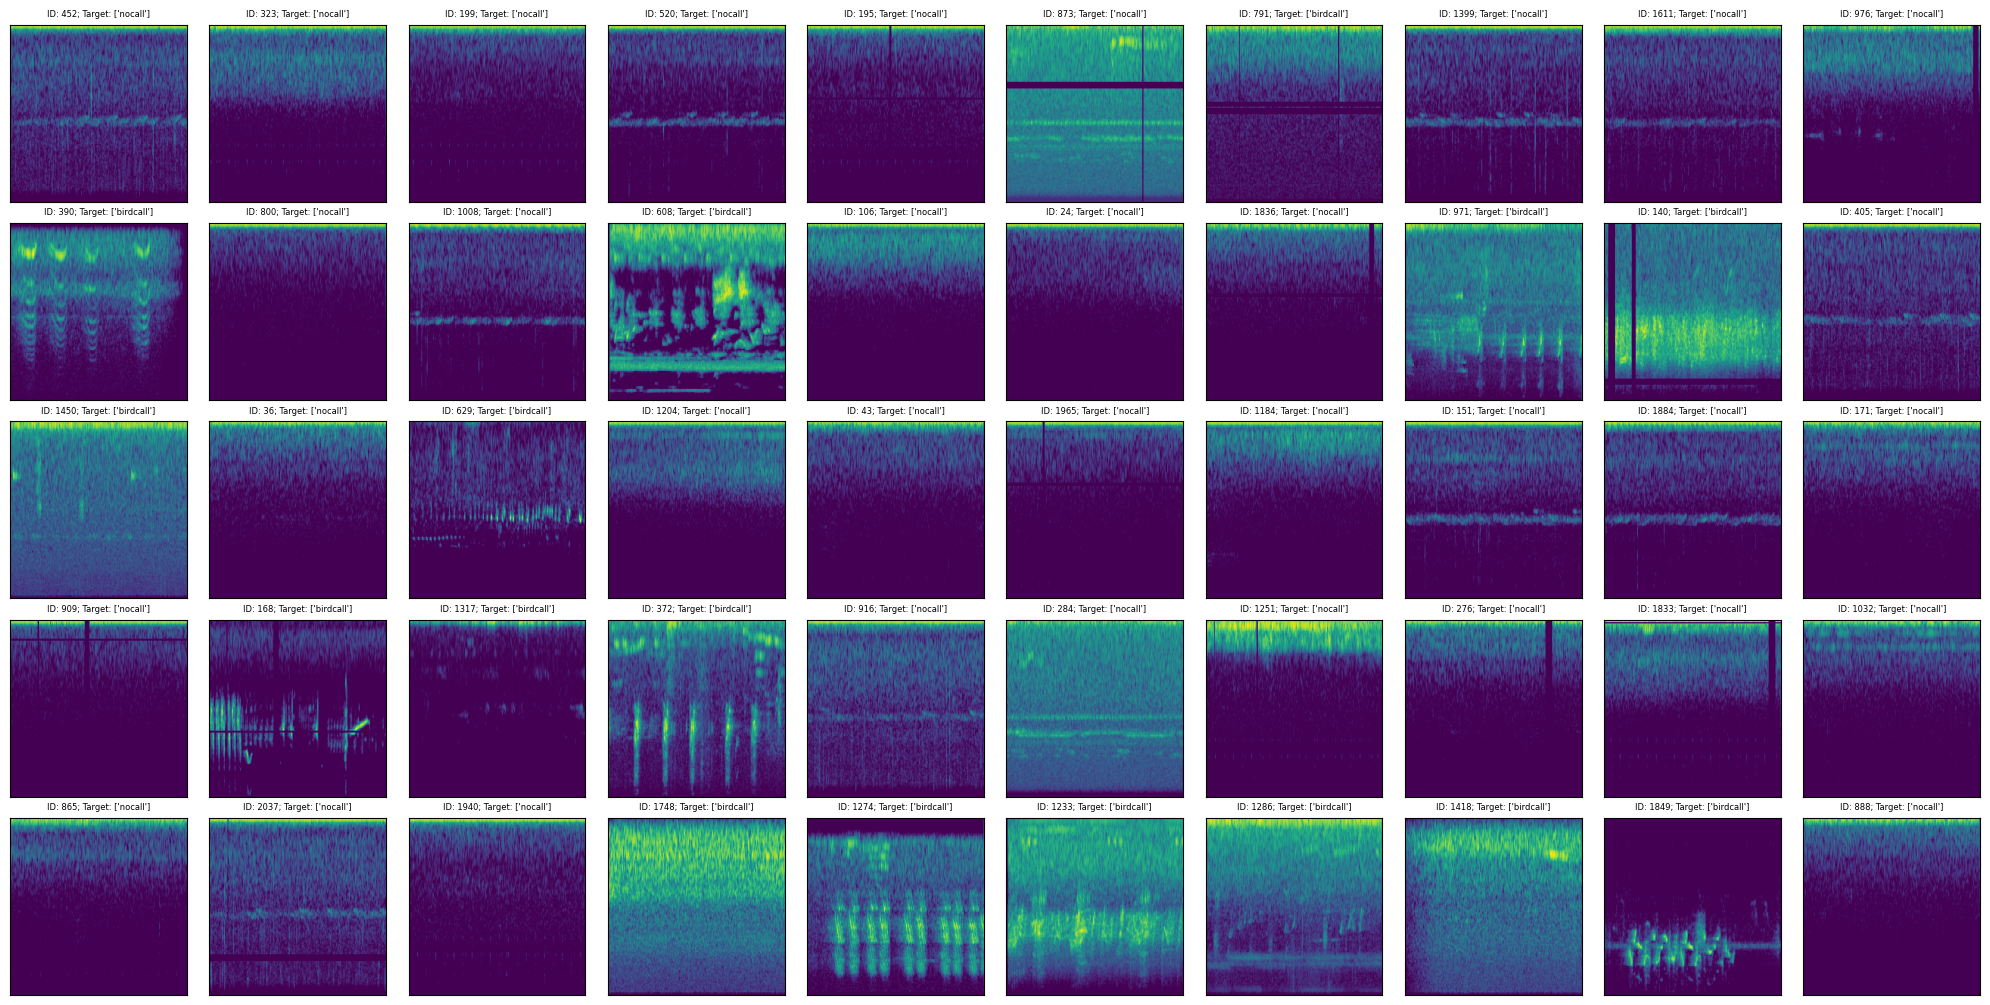

Valid Samples: 515


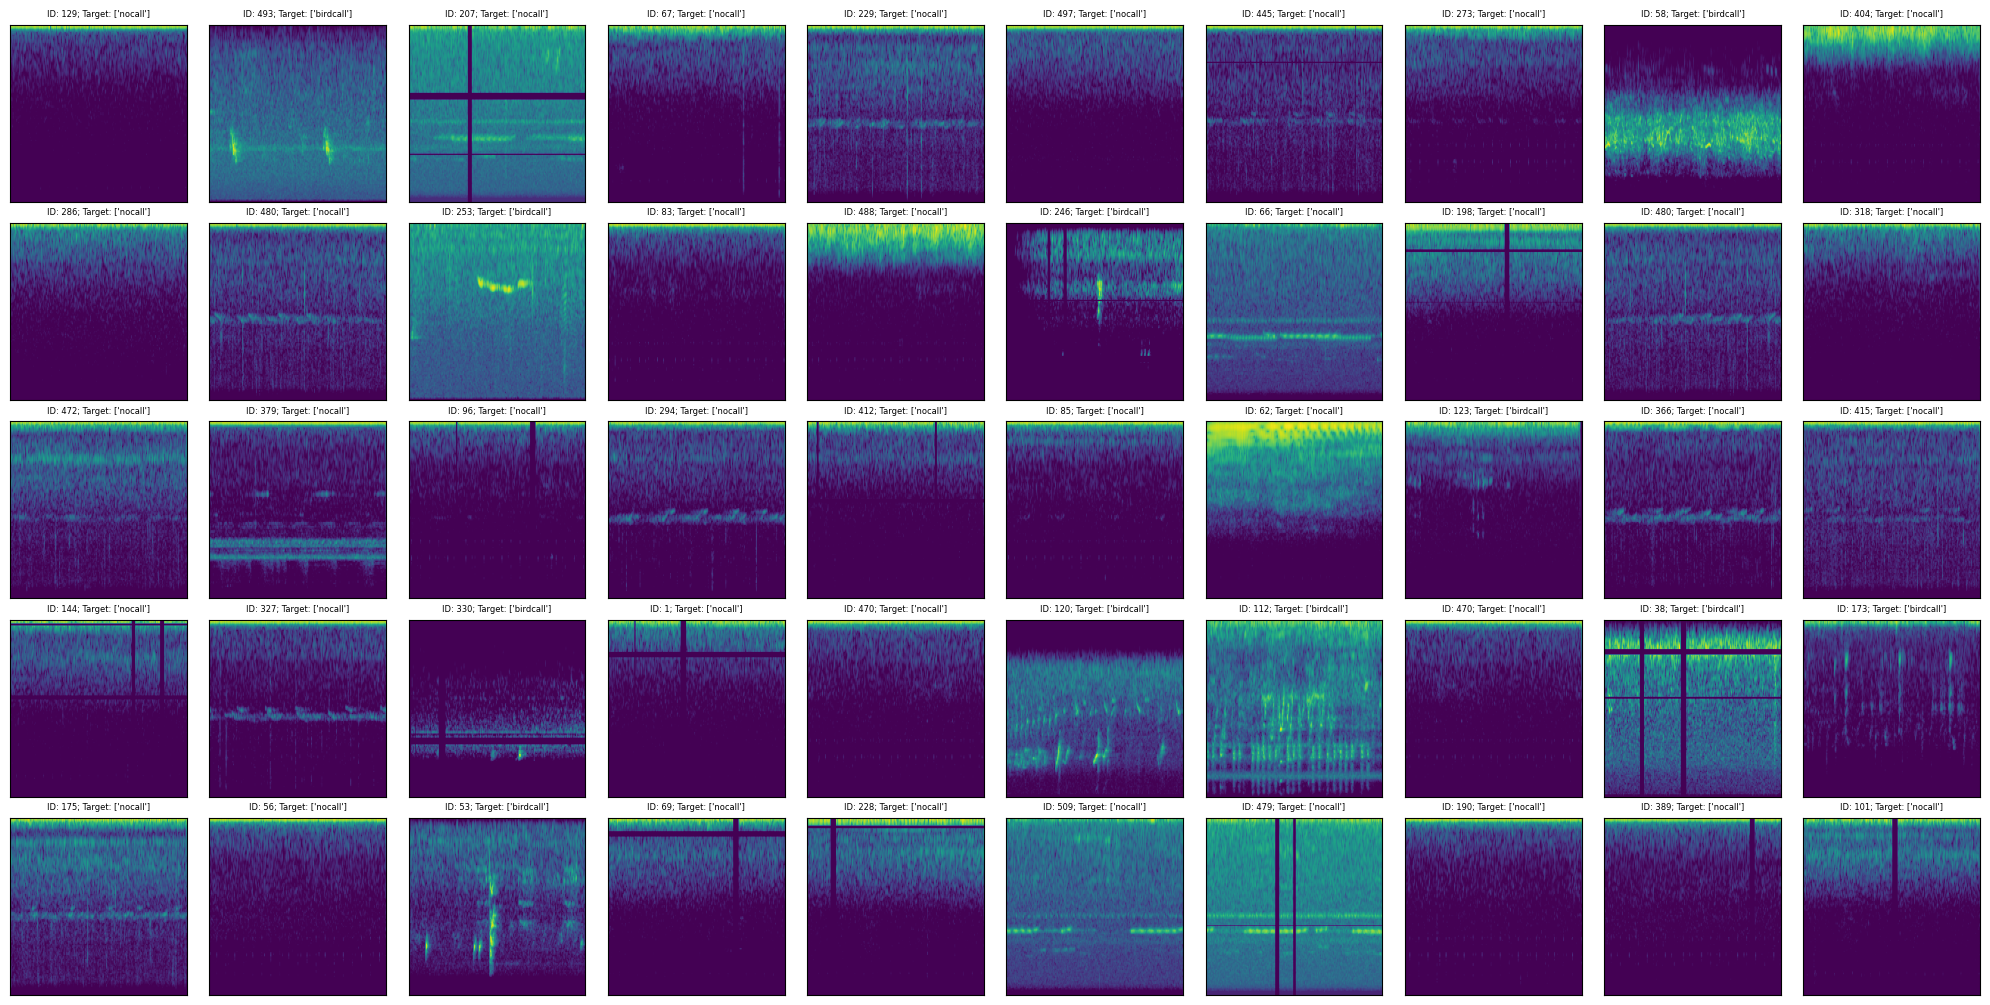

Epoch 1/10, train_loss: 0.1328, valid_loss: 1.0906 valid_acc: 0.0019, lr: [4.817950751404961e-05]
Epoch 2/10, train_loss: 0.1330, valid_loss: 0.1610 valid_acc: 0.0835, lr: [0.0001303507839261669]
Epoch 3/10, train_loss: 0.0026, valid_loss: 0.0134 valid_acc: 0.3029, lr: [0.00016999537033033363]
Epoch 4/10, train_loss: 0.0748, valid_loss: 0.0418 valid_acc: 0.4194, lr: [0.00016119330017358823]
Epoch 5/10, train_loss: 0.0021, valid_loss: 0.0098 valid_acc: 0.5359, lr: [0.00013730027980913016]
Epoch 6/10, train_loss: 0.0025, valid_loss: 0.0222 valid_acc: 0.5204, lr: [0.00010304861494880511]
Epoch 7/10, train_loss: 0.0005, valid_loss: 0.0039 valid_acc: 0.4583, lr: [6.522226788730288e-05]
Epoch 8/10, train_loss: 0.0003, valid_loss: 0.0055 valid_acc: 0.5146, lr: [3.131321056985663e-05]
Epoch 9/10, train_loss: 0.0197, valid_loss: 0.0113 valid_acc: 0.5049, lr: [8.037547665483286e-06]
Epoch 10/10, train_loss: 0.0003, valid_loss: 0.0079 valid_acc: 0.5029, lr: [5.3096696663649245e-09]


In [20]:
if not os.path.exists(f"model/{default_config['VERSION']}"):
    os.makedirs(f"model/{default_config['VERSION']}")

run = wandb.init(project="BirdCLEF2024", name=f"Model_Fold{f}_{default_config['VERSION']}", entity="lhklevi", config=default_config)

print(f'Train Samples: {len(train_dataset)}')
display_batch(train_dataset)

print(f'Valid Samples: {len(valid_dataset)}')
display_batch(valid_dataset)

#-------------Over sampling---------------
sample_weights = [0] * len(train_dataset)
for idx, (data, label) in enumerate(train_dataset):
    sample_weights[idx] = class_weights[label.numpy()[0]]

sampler = WeightedRandomSampler(sample_weights, num_samples=len(train_dataset), replacement=True)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=default_config["BACTHSIZE"], sampler=sampler)
valid_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size=default_config["BACTHSIZE"], shuffle=True)

model = BirdCLEF_Model_EfficientnetB0(num_class=len(label_list)).to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.00017, steps_per_epoch=len(train_dataloader), epochs=default_config["EPOCHS"], anneal_strategy='cos')

# Training loop
for epoch in range(default_config["EPOCHS"]):
    model.train()
    for idx,batch in enumerate(train_dataloader):
        inputs, targets = batch

        inputs = inputs.to(device)
        targets = targets.to(device)
        optimizer.zero_grad()
        # Forward pass
        outputs = model(inputs)
        
        # Compute loss
        loss = criterion(outputs, targets)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        scheduler.step()
        print(f'Step {idx}/{len(train_dataloader)}, Loss: {loss.item():.4f}\r', end='', flush=True)
        wandb.log({"Learning Rate": scheduler.get_last_lr()[0]})
    model.eval()
    valid_step = []
    with torch.no_grad():
        for idx, batch in enumerate(valid_dataloader):
            inputs, targets = batch
            inputs = inputs.to(device)

            outputs = model(inputs)
            valid_step.append({"logits": outputs, "targets": targets})
        
        output_val = torch.cat([x['logits'] for x in valid_step], dim=0).cpu().detach()
        target_val = torch.cat([x['targets'] for x in valid_step], dim=0).cpu().detach()

        val_loss = criterion(output_val, target_val)

        val_acc = torch.sum(output_val==target_val)/len(valid_dataset)
    print(f"Epoch {epoch+1}/{default_config['EPOCHS']}, train_loss: {loss.item():.4f}, valid_loss: {val_loss:.4f} valid_acc: {val_acc:.4f}, lr: {scheduler.get_last_lr()}")
    wandb.log({"Training Loss": loss.item(),"Valid Loss": val_loss ,"Valid ACC": val_acc})
wandb.alert(title=f"Done BirdCall/NoCall !!!", text=f"Done BirdCall/NoCall !!! with {val_acc} accuracy on {len(valid_dataset)} valid")
run.finish()
torch.save(model.state_dict(), f"model/{default_config['VERSION']}/BirdNoCall.pt")

In [21]:
input_names = ['x']
output_names = ['output']

In [25]:
bird_model = BirdCLEF_Model_EfficientnetB0(num_class=len(label_list))
weights = torch.load(f"model/{default_config['VERSION']}/BirdNoCall.pt", map_location=torch.device('cpu'))
bird_model.load_state_dict(weights)
bird_model.eval()

torch.onnx.export(bird_model, input_tensor, f"model/{default_config['VERSION']}/BirdNoCall.onnx", input_names=input_names, output_names=output_names)

### Export model to ONNX

In [22]:
  # input shape
input_names = ['x']
output_names = ['output']
# 
# for fold in range(default_config["FOLD"]):

bird_model = BirdCLEF_Model_EfficientnetB0(num_class=len(label_list))
weights = torch.load(f"model/{default_config['VERSION']}/Model_Fold0.pt", map_location=torch.device('cpu'))
bird_model.load_state_dict(weights)
bird_model.eval()

torch.onnx.export(bird_model, input_tensor, f"model/{default_config['VERSION']}/Model_Fold0.onnx", input_names=input_names, output_names=output_names)

c:\Users\hoang\anaconda3\envs\bird\lib\site-packages\torch\onnx\symbolic_helper.py:1513: UserWarning: ONNX export mode is set to TrainingMode.EVAL, but operator 'batch_norm' is set to train=True. Exporting with train=True.
  warnings.warn(


### Export model to OpenVino

In [23]:
from openvino.runtime import Core
import openvino as ov

import onnx
import onnxruntime as ort

In [24]:
# for fold in range(default_config["FOLD"]):
bird_model = BirdCLEF_Model_EfficientnetB0(num_class=len(label_list))
weights = torch.load(f"model/{default_config['VERSION']}/Model_Fold0.pt", map_location=torch.device('cpu'))
bird_model.load_state_dict(weights)
bird_model.eval()

ov_model = ov.convert_model(bird_model, example_input=input_tensor)
ov.save_model(ov_model, f"model/{default_config['VERSION']}/Model_Fold0.xml")

[ WARNING ]  Please fix your imports. Module %s has been moved to %s. The old module will be deleted in version %s.


### Compare Pytorch vs ONNX vs Openvino

In [ ]:
for batch in valid_dataloader:
    input_tensor, targets = batch
    break


bird_model = BirdCLEF_Model_EfficientnetB0(num_class=len(label_list))
weights = torch.load(f"model/{default_config['VERSION']}/BaseModel_EfficientB0_Fold{fold}.pt", map_location=torch.device('cpu'))
bird_model.load_state_dict(weights)
bird_model.eval()
pytorch_output = bird_model(input_tensor)


onnx_model = onnx.load(f"model/{default_config['VERSION']}/BaseModel_EfficientB0_Fold{fold}.onnx")
onnx_session = ort.InferenceSession(onnx_model.SerializeToString())
onnx_output = onnx_session.run(output_names, {input_names[0]: input_tensor.numpy()})[0]


ie = Core()
classification_model_xml = f"model/{default_config['VERSION']}/BaseModel_EfficientB0_Fold{fold}.xml"
model = ie.read_model(model=classification_model_xml)
compiled_model = ie.compile_model(model=model, device_name="CPU")
output_layer = compiled_model.output(0)
openvino_output = compiled_model([input_tensor])[output_layer]

[ 20 181  57  65  64  63  62  61  60  59]
[ 20  76 120 139   9  55 168  82 129  13]
[ 20  76 120 139   9  55 168  82 129  13]
[ 20  76 120 139   9  55 168  82 129  13]


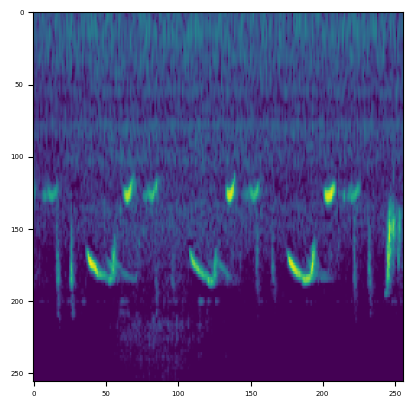

In [ ]:
idx = random.randrange(0,48)
plt.imshow(input_tensor.numpy()[idx].transpose(1,2,0))
print(np.argsort(targets.numpy()[idx])[::-1][:10])

print(np.argsort(pytorch_output.detach().numpy()[idx])[::-1][:10])
print(np.argsort(onnx_output[idx])[::-1][:10])
print(np.argsort(openvino_output[idx])[::-1][:10])

In [ ]:
np.mean(np.absolute((pytorch_output.detach().numpy() - onnx_output)))

1.3004227e-05

In [ ]:
np.mean(np.absolute((pytorch_output.detach().numpy() - openvino_output)))


0.012472135

### PLot the ROC curve for each class

In [ ]:
valid_df = meta_data[meta_data['fold'] == 0].copy()
valid_dataset = BirdCLEF_Dataset(valid_df)
valid_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size=default_config["BACTHSIZE"], shuffle=True)
model = BirdCLEF_Model_EfficientnetB0(num_class=len(label_list))
weights = torch.load(f"model/{default_config['VERSION']}/BaseModel_EfficientB0_Fold0.pt")
model.load_state_dict(weights)

model.eval()
valid_step = []
with torch.no_grad():
    for idx, batch in enumerate(valid_dataloader):
        inputs, targets = batch
        inputs = inputs.to('cpu')

        outputs = model(inputs)
        valid_step.append({"logits": outputs, "targets": targets})
    
    output_val = nn.Softmax(dim=1)(torch.cat([x['logits'] for x in valid_step], dim=0)).cpu().detach()
    target_val = torch.cat([x['targets'] for x in valid_step], dim=0).cpu().detach()
    
    gt_df = pd.DataFrame(target_val.numpy().astype(np.float32), columns=label_list)
    pred_df = pd.DataFrame(output_val.numpy().astype(np.float32), columns=label_list)
    
    gt_df['id'] = [f'id_{i}' for i in range(len(gt_df))]
    pred_df['id'] = [f'id_{i}' for i in range(len(pred_df))]

    val_roc_auc = score(gt_df, pred_df, row_id_column_name='id')

In [ ]:
amount = dict()
for i,amm in enumerate(valid_df["primary_label"].value_counts().to_numpy()):
    amount[i]=amm

In [ ]:
# One hot encode the labels in order to plot them
y_onehot = pd.DataFrame(target_val.numpy())
y_scores = output_val

# Create an empty figure, and iteratively add new lines
# every time we compute a new class
fig = go.Figure()
fig.add_shape(
    type='line', line=dict(dash='dash'),
    x0=0, x1=1, y0=0, y1=1
)

for i in range(y_scores.shape[1]):
    y_true = y_onehot.iloc[:, i]
    y_score = y_scores[:, i]

    fpr, tpr, _ = roc_curve(y_true, y_score)
    auc_score = roc_auc_score(y_true, y_score)

    name = f"{id2label[y_onehot.columns[i]]} (Amount={amount[y_onehot.columns[i]]}) (AUC={auc_score:.2f})"
    fig.add_trace(go.Scatter(x=fpr, y=tpr, name=name, mode='lines'))

fig.update_layout(
    title="ROC curve on Validation set",
    template='plotly_dark',
    xaxis_title='False Positive Rate',
    yaxis_title='True Positive Rate',
    yaxis=dict(scaleanchor="x", scaleratio=1),
    xaxis=dict(constrain='domain')
)
fig.show()

In [ ]:
fig.write_html(f"model/{default_config['VERSION']}/ROC_Curve.html")